
Lambda School Data Science

*Unit 2, Sprint 4, Build Week*

---

## In order to successfully meet the criteria for Build Week, your project must demonstrate that you have done the following:

* Chosen an appropriate dataset (see below).
* Chosen the target from your dataset that your model will predict.
* Specified whether that target requires a regression or a classification model.
* Chosen appropriate performance metrics to evaluate your model.
* Split your dataset into training, test, and (if applicable) validation sets.
* Established a baseline performance score for your dataset.
* Built and trained a linear model for your dataset.
* Built and trained a tree-based model for your dataset.
* Evaluated your models’ performance on the test set in comparison to your baseline.
* Commited your commented code to a GitHub repo.
* Published a blog post reporting on your project that
    * is 300 words long,
    * explains how you chose your dataset and what steps you took to wrangle it,
    * explains which performance metrics you chose and why,
    * details how your models performed on the test set,
    * contains two visualizations learned in Unit 2, accompanied by explanations of what those visualizations show about your model(s).

## Stretch Goals

* Used hyperparameter tuning to improve the performance of your linear model.
* Used hyperparameter tuning to improve the performance of your tree-based model.
* Deployed an interactive web app that uses one of your models. 

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# I. Wrangle Data

In [145]:
DATA_PATH ='../data/esrb/'

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, classification_report

In [147]:
def wrangle(fm_path):
    df = pd.read_csv(DATA_PATH + fm_path,
                    index_col='title')
    # Rename col                
    df = df.rename(columns={'strong_janguage': 'strong_language'})
    # Merge lyrics
    df.loc[df['lyrics']==1, 'lyric_'] = 1
    df.loc[df['mild_lyrics']==1, 'lyric_'] = 2
    df.loc[df['mild_lyrics']==0, 'lyric_'] = 0
    df = df.drop(columns=['lyrics', 'mild_lyrics'])
    # Merge Language
    # df.loc[df['strong_language']==1, 'language_'] = 1
    # df.loc[df['mild_language']==1, 'language_'] = 2
    # df.loc[df['language']==1, 'language_'] = 3
    # df.loc[df['language']==0, 'language_'] = 0
    # df = df.drop(columns=['strong_language', 'mild_language', 'language'])
    # # Merger Nudity
    # df.loc[df['nudity']==1, 'nudity_'] = 1
    # df.loc[df['partial_nudity']==1, 'nudity_'] = 2
    # df.loc[df['nudity']==0, 'nudity_'] = 0
    # df = df.drop(columns=['nudity', 'partial_nudity'])
    # # Mege use of drug and alcohol
    # df.loc[df['use_of_drugs_and_alcohol']==1, 'use_of_drugs_and_alcohol_'] = 1
    # df.loc[df['use_of_alcohol']==1, 'use_of_drugs_and_alcohol_'] = 2
    # df.loc[df['use_of_alcohol']==0, 'use_of_drugs_and_alcohol_'] = 1
    # df = df.drop(columns=['use_of_drugs_and_alcohol', 'use_of_alcohol'])
    # 
    return df
pd.set_option('display.max_columns', None)

In [148]:
df = wrangle('Video_games_esrb_rating.csv')
df_test = wrangle('test_esrb.csv')

# II. Data Exploration

In [149]:
# df_test[(df_test['mild_language']==1) & (df_test['strong_language']==1)]


group:
* use_of_drugs_and_alcohol, use_of_alcohol
* simulated_gambling
* no_descriptors
* nudity, partial_nudity
* lyrics, mild_lyrics
* blood, blood_and_gore
* crude_humor, mature_humor

In [150]:
# df['esrb_rating'] = df['esrb_rating'].map({'T':1, 'E':2, 'ET':3 ,'M':4})

In [151]:
df.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating,lyric_
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,E,0.0
Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ET,0.0
NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,M,0.0
Jamestown+,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ET,0.0
Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,T,0.0


# III. Split Data

In [152]:
target = 'esrb_rating'
X = df.drop(columns=target)
y = df[target]
X_test = df_test.drop(columns=target)
y_test = df_test[target]

In [153]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Establish Baseline

In [154]:
y_train.value_counts(normalize=True).max()

0.36147757255936674

# IV. Build Model

## Random Forest

In [155]:
model_rf = RandomForestClassifier(random_state=42,
                                n_jobs=-2)
model_rf.fit(X_train, y_train);

## SKGB Classifier

In [156]:
model_skgb = GradientBoostingClassifier(random_state=42)
model_skgb.fit(X_train, y_train);

# V. Check Metrics

In [157]:
print('RF Training accuracy', model_rf.score(X_train, y_train))
print('RF Validation accuracy', model_rf.score(X_val, y_val))
print('SKGB Training Accuracy:', model_skgb.score(X_train, y_train))
print('SKGB Validation Accuracy:', model_skgb.score(X_val, y_val))

RF Training accuracy 0.924802110817942
RF Validation accuracy 0.8548812664907651
SKGB Training Accuracy: 0.887203166226913
SKGB Validation Accuracy: 0.8390501319261213


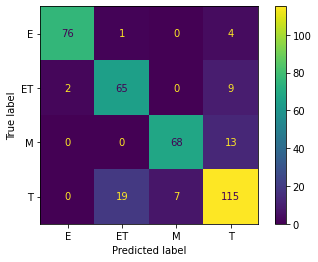

In [158]:
plot_confusion_matrix(model_rf, X_val, y_val)
plt.show()

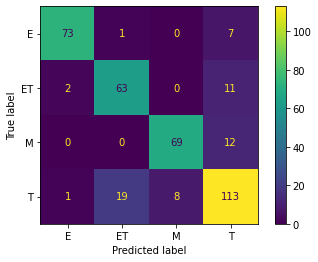

In [159]:
plot_confusion_matrix(model_skgb, X_val, y_val)
plt.show()

In [160]:
report_rf = classification_report(y_val, model_rf.predict(X_val))
print(report_rf)

              precision    recall  f1-score   support

           E       0.97      0.94      0.96        81
          ET       0.76      0.86      0.81        76
           M       0.91      0.84      0.87        81
           T       0.82      0.82      0.82       141

    accuracy                           0.85       379
   macro avg       0.87      0.86      0.86       379
weighted avg       0.86      0.85      0.86       379



In [161]:
report_skgb = classification_report(y_val, model_skgb.predict(X_val))
print(report_skgb)

              precision    recall  f1-score   support

           E       0.96      0.90      0.93        81
          ET       0.76      0.83      0.79        76
           M       0.90      0.85      0.87        81
           T       0.79      0.80      0.80       141

    accuracy                           0.84       379
   macro avg       0.85      0.85      0.85       379
weighted avg       0.84      0.84      0.84       379



# VI. Tune Model

In [127]:
params = {
    'n_estimators': [250, 300, 350, 400],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5, 6, 7]
}

model = GridSearchCV(
    estimator=model_skgb, 
    param_grid=params,
    cv=10,
    n_jobs=-2
)
model.fit(X, y);

KeyboardInterrupt: 

In [21]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8707574491785017
Best params for `model`: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 350}


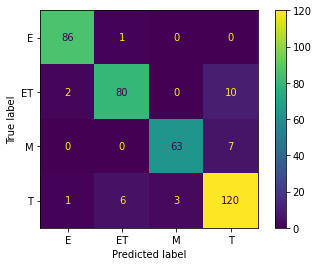

In [22]:
plot_confusion_matrix(model, X_val, y_val)
plt.show()

In [23]:
report = classification_report(y_val, model.predict(X_val))
print(report)

              precision    recall  f1-score   support

           E       0.97      0.99      0.98        87
          ET       0.92      0.87      0.89        92
           M       0.95      0.90      0.93        70
           T       0.88      0.92      0.90       130

    accuracy                           0.92       379
   macro avg       0.93      0.92      0.92       379
weighted avg       0.92      0.92      0.92       379



In [24]:
perm_imp = permutation_importance(
    model,
    X_val, 
    y_val,
    n_repeats=5,
    n_jobs=-2,
    random_state=42
)

In [25]:
data = {'imp_mean': perm_imp['importances_mean'],
      'imp_std': perm_imp['importances_std']}

permu_table = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

(1895, 32)

In [33]:
df.iloc[:100]

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating,lyric_
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,E,0.0
Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ET,0.0
NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,M,0.0
Jamestown+,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ET,0.0
Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,T,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ROBOTICS;NOTES DaSH,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,T,2.0
Sackboy: A Big Adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,E,2.0
Little Nightmares II,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,T,0.0


In [32]:
len(df), df.shape

(1895, (1895, 32))

In [26]:
permu_table

,imp_mean,imp_std
nudity,0.000000,0.000000
mild_language,0.002639,0.001669
use_of_drugs_and_alcohol,0.004749,0.001055
mild_cartoon_violence,0.004749,0.002585
mature_humor,0.005805,0.001055
mild_fantasy_violence,0.006332,0.004894
animated_blood,0.006860,0.003949
sexual_content,0.007388,0.001974
partial_nudity,0.007388,0.001055
drug_reference,0.009499,0.002691


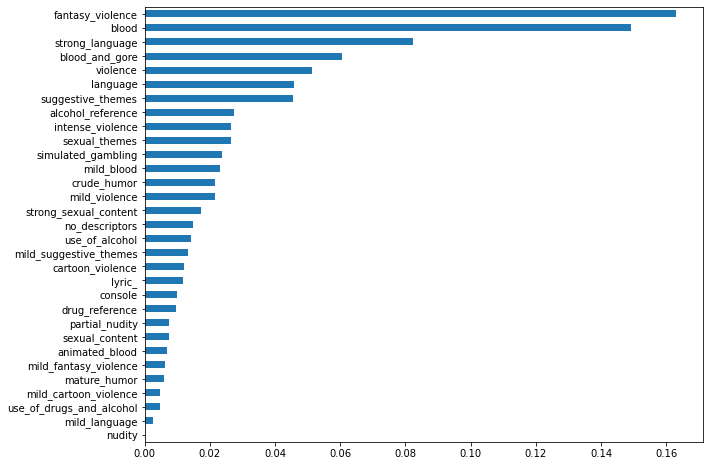

In [27]:
plt.figure(figsize=(10,8))
permu_table['imp_mean'].plot(kind='barh');

## Compare test set

In [28]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           E       0.95      0.95      0.95       100
          ET       0.84      0.83      0.83       126
           M       0.89      0.64      0.75        90
           T       0.76      0.87      0.81       184

    accuracy                           0.83       500
   macro avg       0.86      0.82      0.84       500
weighted avg       0.84      0.83      0.83       500



In [29]:
report = classification_report(y_test, model_rf.predict(X_test))
print(report)

              precision    recall  f1-score   support

           E       0.94      0.91      0.92       100
          ET       0.83      0.80      0.81       126
           M       0.89      0.62      0.73        90
           T       0.74      0.88      0.81       184

    accuracy                           0.82       500
   macro avg       0.85      0.80      0.82       500
weighted avg       0.83      0.82      0.82       500



# VII. Communication

In [56]:

encoder = OrdinalEncoder()
y_encoded = encoder.fit_transform(y_train)
encoder.mapping

[{'col': 'esrb_rating',
  'mapping': M      1
  ET     2
  T      3
  E      4
  NaN   -2
  dtype: int64,
  'data_type': dtype('O')}]

In [61]:
model_rf_encoded = RandomForestClassifier(random_state=42,
                                n_jobs=-2,
                                n_estimators=100, 
                                max_features='auto', 
                                max_depth=9)
model_rf_encoded.fit(X_train, y_encoded);

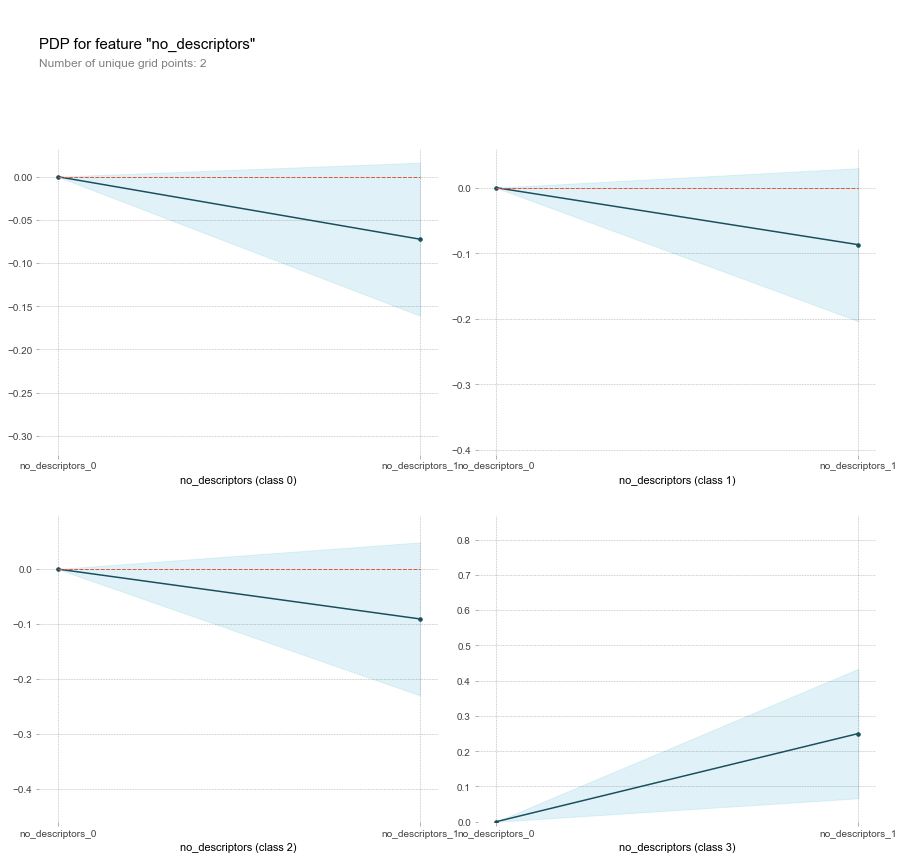

In [62]:
pdp_dist = pdp_isolate(model=model_rf_encoded, dataset=df, model_features=X.columns, feature='no_descriptors')
pdp_plot(pdp_dist, 'no_descriptors');

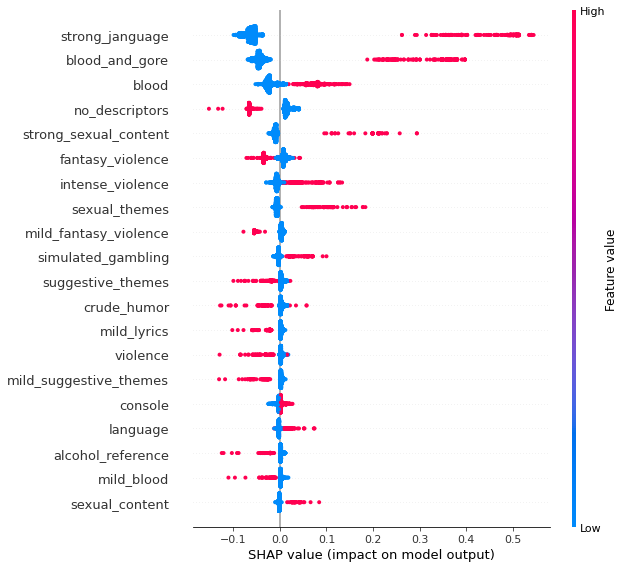

In [64]:
explainer = shap.TreeExplainer(model_rf_encoded)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)

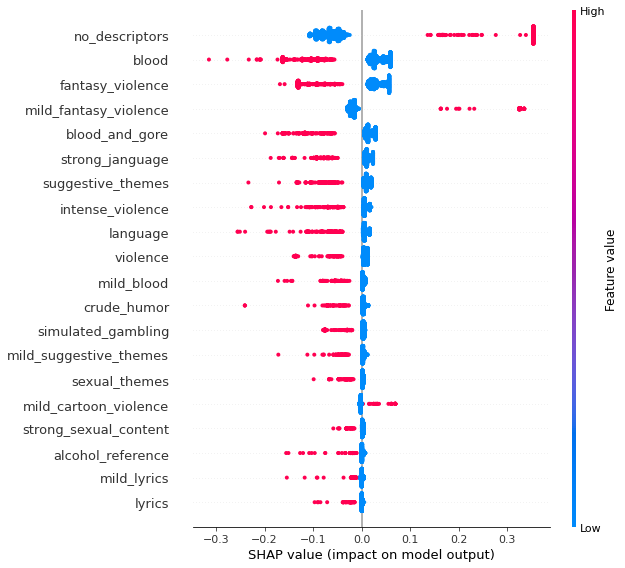

In [68]:
shap.summary_plot(shap_values[3], X_train)

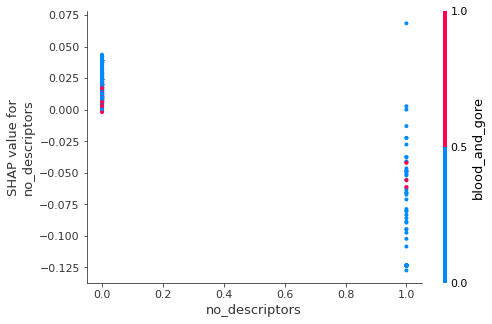

In [72]:
shap.dependence_plot('no_descriptors', shap_values[1], X_train, interaction_index="blood_and_gore")